<a href="https://colab.research.google.com/github/Hoang2531992/Unlearning_HoangTN/blob/main/Unlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import random
import glob
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms, models
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn import linear_model, model_selection
import pickle
import copy
from imblearn.over_sampling import SMOTE


from torchsummary import summary

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device}")

Device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Prepare

## Create MUFAC Dataset

In [ ]:
%%capture
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EbMhBPnmIb5MutZvGicPKggBWKm5hLs0iwKfGW7_TwQIKg?download=1 -O custom_korean_family_dataset_resolution_128.zip
!unzip custom_korean_family_dataset_resolution_128.zip -d ./custom_korean_family_dataset_resolution_128

In [ ]:
"""
> [Function] Parse the metadata.
* image_age_list[0] = ["F0001_AGE_D_18_a1.jpg"] = "a"
* image_age_list[1] = ["F0001_AGE_D_18_a2.jpg"] = "a"
* image_age_list[2] = ["F0001_AGE_D_18_a3.jpg"] = "a"
* image_age_list[3] = ["F0001_AGE_D_18_a4.jpg"] = "a"
* image_age_list[4] = ["F0001_AGE_D_18_b1.jpg"] = "b"
...
"""
def parsing(meta_data):
    image_age_list = []
    # iterate all rows in the metadata file
    for idx, row in meta_data.iterrows():
        image_path = row['image_path']
        age_class = row['age_class']
        image_age_list.append([image_path, age_class])
    return image_age_list

In [ ]:
class MUFAC(Dataset):
    def __init__(self, meta_data, image_directory, transform=None, forget=False, retain=False):
        self.meta_data = meta_data
        self.image_directory = image_directory
        self.transform = transform

        # Process the metadata.
        image_age_list = parsing(meta_data)

        self.image_age_list = image_age_list
        self.age_class_to_label = {
            "a": 0, "b": 1, "c": 2, "d": 3, "e": 4, "f": 5, "g": 6, "h": 7
        }

        # After training the original model, we will do "machine unlearning".
        # The machine unlearning requires two datasets, ① forget dataset and ② retain dataset.
        # In this experiment, we set the first 1,500 images to be forgotten and the rest images to be retained.
        if forget:
            self.image_age_list = self.image_age_list[:1504]
        if retain:
            self.image_age_list = self.image_age_list[1504:]

    def __len__(self):
        return len(self.image_age_list)

    def __getitem__(self, idx):
        image_path, age_class = self.image_age_list[idx]
        img = Image.open(os.path.join(self.image_directory, image_path))
        label = self.age_class_to_label[age_class]

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
# def show_images(images, labels, nrow=6, save_path=None):
#     n_images = len(images)
#     nrows = n_images // nrow + (n_images % nrow > 0)

#     fig, axs = plt.subplots(nrows, nrow, figsize=(14.5, 2.3 * nrows), frameon=False)
#     axs = axs.flatten() if n_images > 1 else [axs]

#     for idx, (img, label) in enumerate(zip(images, labels)):
#         ax = axs[idx]
#         img_np = img.numpy().transpose((1, 2, 0))
#         ax.imshow(img_np)
#         ax.axis('off')

#         ax.text(5, 5, label, color='white', fontsize=13,  ha='left', va='top',
#                 bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.1'))

#     plt.tight_layout(pad=0)

#     if save_path:
#         plt.savefig(save_path, bbox_inches='tight', dpi=300)

#     plt.show()

# iterator = iter(train_dataloader)
# imgs, labels = next(iterator)

# label_strs = [label_to_age[label.item()] for label in labels[7:19]]

# show_images(imgs[7:19], label_strs, nrow=6)

In [ ]:
label_to_age = {
    0: "0-6 years old",
    1: "7-12 years old",
    2: "13-19 years old",
    3: "20-30 years old",
    4: "31-45 years old",
    5: "46-55 years old",
    6: "56-66 years old",
    7: "67-80 years old"
}

train_meta_data_path = "./custom_korean_family_dataset_resolution_128/custom_train_dataset.csv"
train_meta_data = pd.read_csv(train_meta_data_path)
train_image_directory = "./custom_korean_family_dataset_resolution_128/train_images"

test_meta_data_path = "./custom_korean_family_dataset_resolution_128/custom_val_dataset.csv"
test_meta_data = pd.read_csv(test_meta_data_path)
test_image_directory = "./custom_korean_family_dataset_resolution_128/val_images"

unseen_meta_data_path = "./custom_korean_family_dataset_resolution_128/custom_test_dataset.csv"
unseen_meta_data = pd.read_csv(unseen_meta_data_path)
unseen_image_directory = "./custom_korean_family_dataset_resolution_128/test_images"

train_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

val_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

test_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor()
])

train_dataset = MUFAC(train_meta_data, train_image_directory, train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)

val_dataset = MUFAC(test_meta_data, test_image_directory, val_transform)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)

test_dataset = MUFAC(unseen_meta_data, unseen_image_directory, test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

forget_dataset_train = MUFAC(train_meta_data, train_image_directory, val_transform, forget=True)
forget_dataloader_train = DataLoader(forget_dataset_train, batch_size=256, shuffle=True)

retain_dataset_train = MUFAC(train_meta_data, train_image_directory, val_transform, retain=True)
retain_dataloader_train = DataLoader(retain_dataset_train, batch_size=256, shuffle=True)

forget_dataset_test = MUFAC(train_meta_data, train_image_directory, val_transform, forget=True)
forget_dataloader_test = DataLoader(forget_dataset_test, batch_size=256, shuffle=False)

retain_dataset_test = MUFAC(train_meta_data, train_image_directory, val_transform, retain=True)
retain_dataloader_test = DataLoader(retain_dataset_test, batch_size=256, shuffle=False)


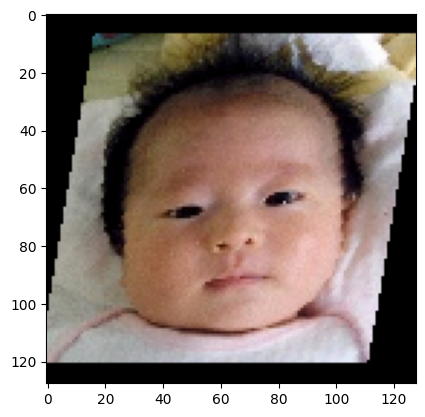

In [ ]:
image = train_dataset[0][0]
image = np.transpose(image.numpy(), (1, 2, 0))

plt.imshow(image)

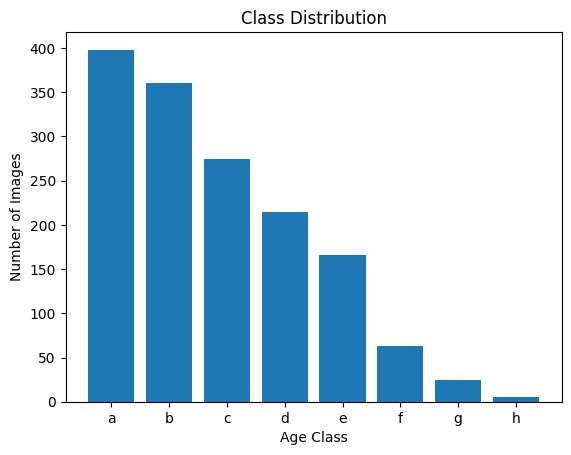

In [ ]:
# prompt: visualize class distribution from /content/custom_korean_family_dataset_resolution_128/custom_train_dataset.csv file

import pandas as pd
import matplotlib.pyplot as plt

meta_data_path = "/content/custom_korean_family_dataset_resolution_128/custom_test_dataset.csv"
meta_data = pd.read_csv(meta_data_path)

age_classes = meta_data['age_class'].value_counts()

plt.bar(age_classes.index, age_classes.values)
plt.xlabel('Age Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.show()


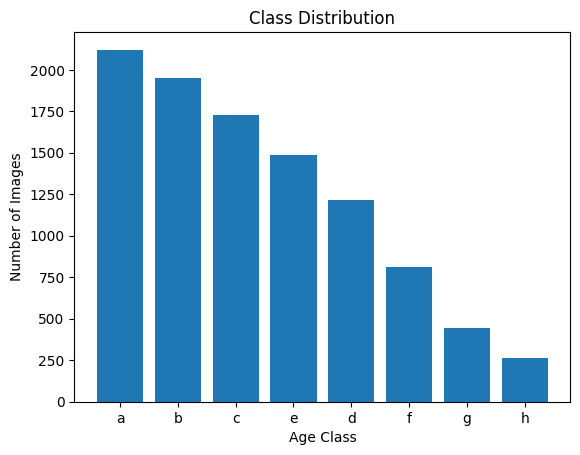

In [ ]:
# prompt: visualize class distribution from /content/custom_korean_family_dataset_resolution_128/custom_train_dataset.csv file

import pandas as pd
import matplotlib.pyplot as plt

meta_data_path = "/content/custom_korean_family_dataset_resolution_128/custom_train_dataset.csv"
meta_data = pd.read_csv(meta_data_path)

age_classes = meta_data['age_class'].value_counts()

plt.bar(age_classes.index, age_classes.values)
plt.xlabel('Age Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.show()


## Train Model

### Utils

In [ ]:
@torch.no_grad()
def evaluation(model, data_loader):
    start_time = time.time()
    print(f'[Test]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0
    running_top2_corrects = 0
    log_step = 20

    for i, batch in enumerate(data_loader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Top-2 accuracy.
            _, top2_preds = outputs.topk(2, dim=1)  # Get the top 2 class indices.  #Why?????????????????????????????????????
            top2_correct = top2_preds.eq(labels.view(-1, 1).expand_as(top2_preds))
            running_top2_corrects += top2_correct.any(dim=1).sum().item()

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data).item()

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}, running top-2 accuracy: {running_top2_corrects / total}')

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}, top-2 accuracy: {running_top2_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return {'Loss': running_loss / total, 'Acc': running_corrects / total, 'Top-2 Acc': running_top2_corrects / total}

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

In [ ]:
def calculate_loss(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    total_samples = 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.cuda(), y.cuda()
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item() * x.size(0)
            total_samples += x.size(0)

    average_loss = total_loss / total_samples
    return average_loss

def calculate_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.cuda(), y.cuda()
            outputs = model(x)
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

    accuracy = 100 * correct / total
    return accuracy

### Pretrain Model

In [ ]:
# set_seed(42)

In [ ]:
pretrain_model = models.resnet18(pretrained=False)
num_features = pretrain_model.fc.in_features
pretrain_model.fc = nn.Linear(num_features, 8)
pretrain_model = pretrain_model.cuda()

In [ ]:
epochs = 20

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrain_model.parameters(), lr=0.001, weight_decay = 1e-5)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=0, last_epoch=-1, verbose=False)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


for epoch in range(epochs):
    pretrain_model.train()
    running_loss = 0

    for batch_idx, (x, y) in enumerate(train_dataloader):
        y = y.cuda()

        # Classification Loss
        outputs = pretrain_model(x.cuda())
        classification_loss = criterion(outputs, y)

        optimizer.zero_grad()
        classification_loss.backward()
        optimizer.step()
        # scheduler.step()

        running_loss += classification_loss.item() * x.size(0)
        # print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(train_dataloader)}] - Batch Loss: {classification_loss.item():.4f}")

    train_loss = running_loss / len(train_dataloader.dataset)
    val_loss = calculate_loss(pretrain_model, val_dataloader, criterion)
    print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f} - Val Loss: {val_loss}")

    if (epoch+1)%5==0:
        train_acc = calculate_accuracy(pretrain_model, train_dataloader)
        val_acc = calculate_accuracy(pretrain_model, val_dataloader)

    # train_losses.append(train_loss)
    # val_losses.append(val_loss)
    # train_accuracies.append(train_acc)
    # val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.2f}, Val Acc: {val_acc:.2f}")

Epoch [1/20] - Train Loss: 1.7909 - Val Loss: 2.0064874656638825
Epoch [2/20] - Train Loss: 1.4846 - Val Loss: 1.4333294006506292
Epoch [3/20] - Train Loss: 1.3600 - Val Loss: 1.7516043588974168
Epoch [4/20] - Train Loss: 1.2648 - Val Loss: 1.540761321918619
Epoch [5/20] - Train Loss: 1.1951 - Val Loss: 1.337954632642596
Epoch [5/20] - Train Loss: 1.1951, Val Loss: 1.3380, Train Acc: 48.78, Val Acc: 45.61
Epoch [6/20] - Train Loss: 1.1417 - Val Loss: 1.3306276584461652
Epoch [7/20] - Train Loss: 1.0873 - Val Loss: 1.374810427640304
Epoch [8/20] - Train Loss: 1.0198 - Val Loss: 1.681483175632162
Epoch [9/20] - Train Loss: 1.0010 - Val Loss: 1.3791443742351768
Epoch [10/20] - Train Loss: 0.9442 - Val Loss: 1.1673801194699729
Epoch [10/20] - Train Loss: 0.9442, Val Loss: 1.1674, Train Acc: 59.66, Val Acc: 51.53
Epoch [11/20] - Train Loss: 0.9022 - Val Loss: 1.411059391196476
Epoch [12/20] - Train Loss: 0.8846 - Val Loss: 1.5814731344144943
Epoch [13/20] - Train Loss: 0.8222 - Val Loss: 1.

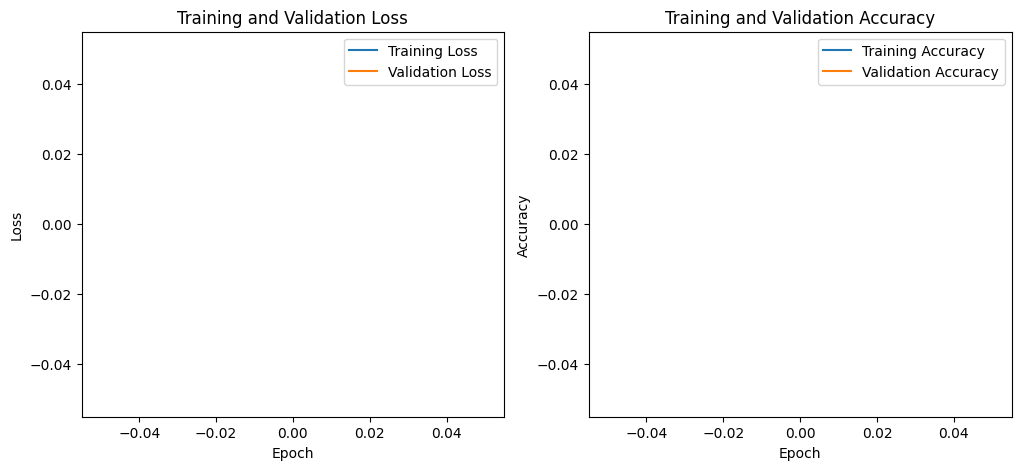

In [ ]:
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Retrain Model

In [ ]:
retrain_model = models.resnet18(pretrained=False)
num_features = retrain_model.fc.in_features
retrain_model.fc = nn.Linear(num_features, 8)
retrain_model = retrain_model.cuda()

In [ ]:
epochs = 20

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(retrain_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=0, last_epoch=-1, verbose=False)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


for epoch in range(epochs):
    retrain_model.train()
    running_loss = 0

    for batch_idx, (x, y) in enumerate(retain_dataloader_train):
        y = y.cuda()

        # Classification Loss
        outputs = retrain_model(x.cuda())
        classification_loss = criterion(outputs, y)

        optimizer.zero_grad()
        classification_loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += classification_loss.item() * x.size(0)
        print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(retain_dataloader_train)}] - Batch Loss: {classification_loss.item():.4f}")

    average_epoch_loss = running_loss / (len(retain_dataloader_train) * x.size(0))
    print(f"Epoch [{epoch+1}/{epochs}] - Total Loss: {running_loss:.4f}")

    train_loss = running_loss / len(retain_dataloader_train.dataset)
    val_loss = calculate_loss(retrain_model, test_dataloader, criterion)
    train_acc = calculate_accuracy(retrain_model, retain_dataloader_train)
    val_acc = calculate_accuracy(retrain_model, test_dataloader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.2f}, Val Acc: {val_acc:.2f}")

Epoch [1/20], Batch [1/134] - Batch Loss: 2.0112
Epoch [1/20], Batch [2/134] - Batch Loss: 2.6741
Epoch [1/20], Batch [3/134] - Batch Loss: 2.4203
Epoch [1/20], Batch [4/134] - Batch Loss: 1.9980
Epoch [1/20], Batch [5/134] - Batch Loss: 1.9075
Epoch [1/20], Batch [6/134] - Batch Loss: 2.3772
Epoch [1/20], Batch [7/134] - Batch Loss: 1.8723
Epoch [1/20], Batch [8/134] - Batch Loss: 2.0368
Epoch [1/20], Batch [9/134] - Batch Loss: 1.8283
Epoch [1/20], Batch [10/134] - Batch Loss: 1.7570
Epoch [1/20], Batch [11/134] - Batch Loss: 1.7566
Epoch [1/20], Batch [12/134] - Batch Loss: 1.8953
Epoch [1/20], Batch [13/134] - Batch Loss: 1.8976
Epoch [1/20], Batch [14/134] - Batch Loss: 1.8894
Epoch [1/20], Batch [15/134] - Batch Loss: 1.8398
Epoch [1/20], Batch [16/134] - Batch Loss: 1.9793
Epoch [1/20], Batch [17/134] - Batch Loss: 1.9210
Epoch [1/20], Batch [18/134] - Batch Loss: 1.8234
Epoch [1/20], Batch [19/134] - Batch Loss: 1.9010
Epoch [1/20], Batch [20/134] - Batch Loss: 1.7960
Epoch [1/

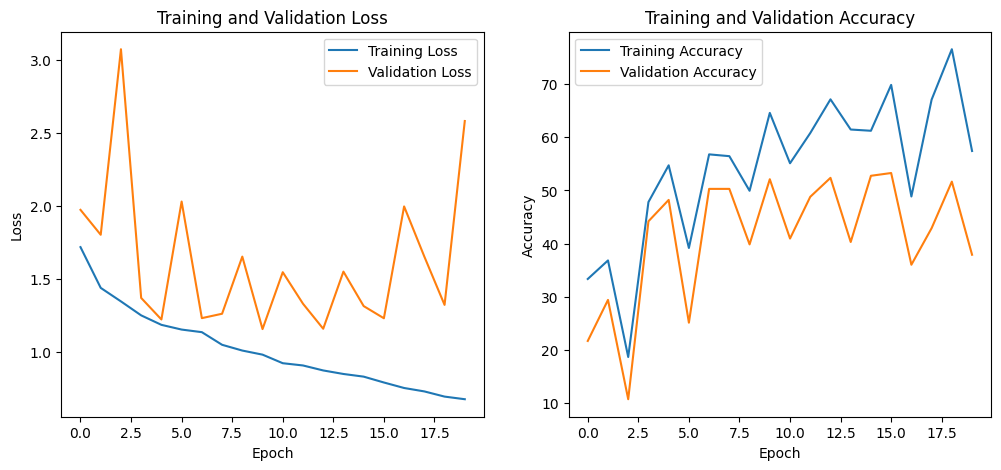

In [ ]:
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# Save model
# torch.save(pretrain_model.state_dict(), "./pretrain_model.pth")
torch.save(retrain_model.state_dict(), "./retrain_model.pth")

In [ ]:
from google.colab import files
files.download('retrain_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Attack Model

In [ ]:
def compute_losses(models, loader):
    criterion = nn.CrossEntropyLoss(reduction="none")
    # all_losses = []
    all_log = []

    for model in models:
        for inputs, y in loader:
            targets = y
            inputs, targets = inputs.cuda(), targets.cuda()

            logits = model(inputs).cpu().detach().numpy()

            for l in logits:
                all_log.append(l)


            # losses = criterion(logits, targets).cpu().detach().numpy()
            # for l in losses:
            #     all_losses.append(l)

    return np.array(all_log)

# def simple_mia(sample_loss, members, n_splits=10, random_state=0):
#     unique_members = np.unique(members)
#     if not np.all(unique_members == np.array([0, 1])):
#         raise ValueError("members should only have 0 and 1s")

#     attack_model = linear_model.LogisticRegression()
#     cv = model_selection.StratifiedShuffleSplit(
#         n_splits=n_splits, random_state=random_state
#     )
#     return model_selection.cross_val_score(
#         attack_model, sample_loss, members, cv=cv, scoring="accuracy"
#     )


# def cal_mia(model):
#     set_seed(42)

#     forget_losses = compute_losses(model, forget_dataloader_test)
#     unseen_losses = compute_losses(model, unseen_dataloader)

#     np.random.shuffle(forget_losses)
#     forget_losses = forget_losses[: len(unseen_losses)]

#     samples_mia = np.concatenate((unseen_losses, forget_losses)).reshape((-1, 1))
#     labels_mia = [0] * len(unseen_losses) + [1] * len(forget_losses)

#     mia_scores = simple_mia(samples_mia, labels_mia)
#     forgetting_score = abs(0.5 - mia_scores.mean())

#     return {'MIA': mia_scores.mean(), 'Forgeting Score': forgetting_score}


### Train Shadow Models

In [ ]:
def train_shadow_model():

    model = models.resnet18(pretrained=False)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 8)
    model = model.cuda()

    epochs = 20

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=0, last_epoch=-1, verbose=False)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []


    for epoch in range(epochs):
        model.train()
        running_loss = 0

        for batch_idx, (x, y) in enumerate(train_dataloader):
            y = y.cuda()

            # Classification Loss
            outputs = model(x.cuda())
            classification_loss = criterion(outputs, y)

            optimizer.zero_grad()
            classification_loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += classification_loss.item() * x.size(0)

        print(f"Epoch [{epoch+1}/{epochs}] - Total Loss: {running_loss:.4f}")

        if (epoch+1)%5==0:
            train_acc = calculate_accuracy(model, retain_dataloader_test)
            val_acc = calculate_accuracy(model, test_dataloader)

            print(f"Epoch [{epoch+1}/{epochs}] - Train Acc: {train_acc:.2f}, Val Acc: {val_acc:.2f}")
    return model

In [ ]:
shadow_models = []
for i in range(16, 100):
  print(f"Model {i+1}:")
  model = train_shadow_model()
  torch.save(model, f'/content/drive/MyDrive/AI/MachineUnlearn/ShadowModels/shadow_{i}.pth')
  shadow_models.append(model)

Model 17:
Epoch [1/20] - Total Loss: 17559.8593
Epoch [2/20] - Total Loss: 14792.2195
Epoch [3/20] - Total Loss: 13566.1047
Epoch [4/20] - Total Loss: 12831.2199
Epoch [5/20] - Total Loss: 12302.1395
Epoch [5/20] - Train Acc: 57.46, Val Acc: 54.19
Epoch [6/20] - Total Loss: 11619.7279
Epoch [7/20] - Total Loss: 11317.2098
Epoch [8/20] - Total Loss: 10950.0150
Epoch [9/20] - Total Loss: 10625.0199
Epoch [10/20] - Total Loss: 10112.4039
Epoch [10/20] - Train Acc: 62.87, Val Acc: 55.39
Epoch [11/20] - Total Loss: 9985.3416
Epoch [12/20] - Total Loss: 9479.0120
Epoch [13/20] - Total Loss: 9087.1050
Epoch [14/20] - Total Loss: 8778.2692
Epoch [15/20] - Total Loss: 8563.9635
Epoch [15/20] - Train Acc: 69.38, Val Acc: 52.86
Epoch [16/20] - Total Loss: 8196.6711
Epoch [17/20] - Total Loss: 7867.6123
Epoch [18/20] - Total Loss: 7828.8708
Epoch [19/20] - Total Loss: 7348.8033
Epoch [20/20] - Total Loss: 7015.0313
Epoch [20/20] - Train Acc: 80.64, Val Acc: 60.37
Model 18:
Epoch [1/20] - Total Los

KeyboardInterrupt: 

### Train Attack Model

In [ ]:
shadow_models = []

for i in range(20):
    shadow_models.append(torch.load(f"/content/drive/MyDrive/AI/MachineUnlearn/ShadowModels/shadow_{i}.pth"))

In [ ]:
retain_losses = compute_losses(shadow_models, retain_dataloader_test)
forget_losses = compute_losses(shadow_models, forget_dataloader_test)
val_losses = compute_losses(shadow_models, val_dataloader)

In [ ]:
members_losses = np.concatenate((retain_losses, forget_losses))
np.random.shuffle(members_losses)
members_losses = members_losses[: len(val_losses)]
samples_mia = np.concatenate((val_losses, members_losses))

labels_mia = [0] * len(val_losses) + [1] * len(members_losses)
np.random.shuffle(samples_mia)

In [ ]:
labels_mia[1000]

0

In [ ]:
attack_model = linear_model.LogisticRegression()
attack_model.fit(samples_mia, labels_mia)

LogisticRegression()

In [ ]:
import pickle

# save
with open('attack_model.pkl','wb') as f:
    pickle.dump(attack_model,f)

### Test Attack Model

In [ ]:
pretrain_model = models.resnet18(pretrained=False)
num_features = pretrain_model.fc.in_features
pretrain_model.fc = nn.Linear(num_features, 8)
pretrain_model = pretrain_model.cuda()
pretrain_model.load_state_dict(torch.load("/content/pretrain_model.pth"))

<All keys matched successfully>

In [ ]:
with open('/content/drive/MyDrive/AI/MachineUnlearn/attack_model.pkl', 'rb') as f:
    attack_model = pickle.load(f)

In [ ]:
retrain_forget_losses = compute_losses([retrain_model], forget_dataloader_test)
retrain_unseen_losses = compute_losses([retrain_model], test_dataloader)

In [ ]:
len(retrain_unseen_losses)

1504

In [ ]:
# prompt: take prediction from attack_model

predictions = attack_model.predict(retrain_forget_losses)


In [ ]:
np.average(predictions)

0.5179521276595744

# Unlearn

In [ ]:
def compute_losses(models, loader):
    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for model in models:
        for inputs, y in loader:
            targets = y
            inputs, targets = inputs.cuda(), targets.cuda()

            logits = model(inputs)

            losses = criterion(logits, targets).cpu().detach().numpy()
            for l in losses:
                all_losses.append(l)

    return np.array(all_losses)

def calculate_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.cuda(), y.cuda()
            outputs = model(x)
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

    accuracy = 100 * correct / total
    return accuracy

def cal_mia(model, data):
    try:
        attack_model
    except:
        with open('/content/drive/MyDrive/AI/MachineUnlearn/old_attack_model.pkl', 'rb') as f:
            attack_model = pickle.load(f)

    losses = compute_losses([model], data)
    score = np.average(attack_model.predict(losses.reshape((-1, 1))))
    print(f"MIA Scores: {score}")
    return score

def cal_acc(model, name):
    print(f"Accuracy of {name} Model on Retain Set", calculate_accuracy(model, retain_dataloader_test))
    print(f"Accuracy of {name} Model on Forget Set", calculate_accuracy(model, forget_dataloader_test))
    print(f"Accuracy of {name} Model on Test Set", calculate_accuracy(model, test_dataloader))

## Test on Pretrain Model

In [ ]:
# Load Pretrain
pretrain_model = models.resnet18(pretrained=False)
num_features = pretrain_model.fc.in_features
pretrain_model.fc = nn.Linear(num_features, 8)
pretrain_model = pretrain_model.to(device)
pretrain_model.load_state_dict(torch.load("/content/drive/MyDrive/AI/MachineUnlearn/pretrain_model.pth"))

<All keys matched successfully>

In [ ]:
cal_acc(pretrain_model, "Pretrain")

Accuracy of Pretrain Model on Retain Set 80.02581856589602
Accuracy of Pretrain Model on Forget Set 78.39095744680851
Accuracy of Pretrain Model on Test Set 57.97872340425532


In [ ]:
cal_mia(pretrain_model, forget_dataloader_test)

MIA Scores: 0.7513297872340425


0.7513297872340425

## Test on Retrain Model

In [ ]:
# Load Pretrain
retrain_model = models.resnet18(pretrained=False)
num_features = retrain_model.fc.in_features
retrain_model.fc = nn.Linear(num_features, 8)
retrain_model = retrain_model.cuda()
retrain_model.load_state_dict(torch.load("/content/drive/MyDrive/AI/MachineUnlearn/retrain_model.pth"))

<All keys matched successfully>

In [ ]:
cal_acc(retrain_model, "Retrain")
cal_mia(retrain_model, forget_dataloader_test)

MIA Scores: 0.3484042553191489


0.3484042553191489

## Fine Tune

In [ ]:
def finetune(model):
    epochs = 2
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001)
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=0, last_epoch=-1, verbose=False)

    for epoch in range(epochs):
        model.train()
        running_loss = 0

        for batch_idx, (x, y) in enumerate(retain_dataloader_test):
            y = y.cuda()

            # Classification Loss
            outputs = model(x.cuda())
            classification_loss = criterion(outputs, y)

            optimizer.zero_grad()
            classification_loss.backward()
            optimizer.step()
            # scheduler.step()

            running_loss += classification_loss.item() * x.size(0)
            print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(retain_dataloader_test)}] - Batch Loss: {classification_loss.item():.4f}")

        average_epoch_loss = running_loss / (len(retain_dataloader_test) * x.size(0))
        print(f"Epoch [{epoch+1}/{epochs}] - Total Loss: {running_loss:.4f}")

        train_acc = calculate_accuracy(model, retain_dataloader_test)
        val_acc = calculate_accuracy(model, test_dataloader)

        # print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.2f}, Val Acc: {val_acc:.2f}")

    return model

In [ ]:
finetuneModel = copy.deepcopy(pretrain_model)
cal_acc(finetuneModel, "Fine Tune")

Accuracy of Fine Tune Model on Retain Set 80.02581856589602
Accuracy of Fine Tune Model on Forget Set 78.39095744680851
Accuracy of Fine Tune Model on Test Set 57.97872340425532


In [ ]:
finetuneModel = finetune(finetuneModel)

In [ ]:
cal_acc(finetuneModel, "Fine Tune")
cal_mia(finetuneModel, forget_dataloader_test)

Accuracy of Fine Tune Model on Retain Set 81.46931111371904
Accuracy of Fine Tune Model on Forget Set 78.98936170212765
Accuracy of Fine Tune Model on Test Set 54.52127659574468
MIA Scores: 0.7652925531914894


0.7652925531914894

## Amnesiac

In [ ]:
def fit_epochs(epochs, model, dataset):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=0, last_epoch=-1, verbose=False)

    for epoch in range(epochs):
        model.train()
        running_loss = 0

        for batch_idx, (x, y) in enumerate(dataset):
            y = y.cuda()

            # Classification Loss
            outputs = model(x.cuda())
            classification_loss = criterion(outputs, y)

            optimizer.zero_grad()
            classification_loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += classification_loss.item() * x.size(0)
            print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(dataset)}] - Batch Loss: {classification_loss.item():.4f}")

        average_epoch_loss = running_loss / (len(dataset) * x.size(0))
        print(f"Epoch [{epoch+1}/{epochs}] - Total Loss: {running_loss:.4f}")

        train_acc = calculate_accuracy(model, dataset)
        val_acc = calculate_accuracy(model, test_dataloader)

        print(f"Epoch [{epoch+1}/{epochs}] - Train Acc: {train_acc:.2f}, Val Acc: {val_acc:.2f}")

    return model

In [ ]:
import random

def amnesiac(
    model,
    retain_train_dl,
    forget_train_dl,
    num_classes,
    epochs = 4,
    device = 'cuda',
    **kwargs,
):
    unlearninglabels = list(range(num_classes))
    unlearning_trainset = []

    for x, label in forget_train_dl.dataset:
        rnd = random.choice(unlearninglabels)
        while rnd == label:
            rnd = random.choice(unlearninglabels)
        unlearning_trainset.append((x, rnd))

    # for x, y in retain_train_dl.dataset:
    #     unlearning_trainset.append((x, y))

    unlearning_train_set_dl = DataLoader(
        unlearning_trainset, 128, pin_memory=True, shuffle=True
    )

    _ = fit_epochs(epochs, model, unlearning_train_set_dl)

In [ ]:
amnesiac_model = copy.deepcopy(pretrain_model)

In [ ]:
cal_acc(amnesiac_model, "Amnesiac")
cal_mia(amnesiac_model, forget_dataloader_test)

Accuracy of Amnesiac Model on Retain Set 61.107851191174746
Accuracy of Amnesiac Model on Forget Set 59.50797872340426
Accuracy of Amnesiac Model on Test Set 46.609042553191486
MIA Scores: 0.5472074468085106


0.5472074468085106

In [ ]:
amnesiac(amnesiac_model, retain_dataloader_train, forget_dataloader_train, 8, 10)

Epoch [1/10], Batch [1/12] - Batch Loss: 7.9233
Epoch [1/10], Batch [2/12] - Batch Loss: 8.4771
Epoch [1/10], Batch [3/12] - Batch Loss: 7.5695
Epoch [1/10], Batch [4/12] - Batch Loss: 7.6496
Epoch [1/10], Batch [5/12] - Batch Loss: 7.4244
Epoch [1/10], Batch [6/12] - Batch Loss: 7.6575
Epoch [1/10], Batch [7/12] - Batch Loss: 8.1281
Epoch [1/10], Batch [8/12] - Batch Loss: 7.6096
Epoch [1/10], Batch [9/12] - Batch Loss: 7.9083
Epoch [1/10], Batch [10/12] - Batch Loss: 7.0649
Epoch [1/10], Batch [11/12] - Batch Loss: 7.5782
Epoch [1/10], Batch [12/12] - Batch Loss: 7.3722
Epoch [1/10] - Total Loss: 11586.5164
Epoch [1/10] - Train Acc: 2.59, Val Acc: 57.38
Epoch [2/10], Batch [1/12] - Batch Loss: 7.4801
Epoch [2/10], Batch [2/12] - Batch Loss: 7.9993
Epoch [2/10], Batch [3/12] - Batch Loss: 7.8358
Epoch [2/10], Batch [4/12] - Batch Loss: 7.1425
Epoch [2/10], Batch [5/12] - Batch Loss: 7.8082
Epoch [2/10], Batch [6/12] - Batch Loss: 7.5520
Epoch [2/10], Batch [7/12] - Batch Loss: 7.9176


In [ ]:
cal_acc(amnesiac_model, "Amnesiac")
cal_mia(amnesiac_model, forget_dataloader_test)

Accuracy of Amnesiac Model on Retain Set 61.107851191174746
Accuracy of Amnesiac Model on Forget Set 59.50797872340426
Accuracy of Amnesiac Model on Test Set 46.609042553191486
MIA Scores: 0.5472074468085106


0.5472074468085106

## SCRUB

In [ ]:
class DistillKL(nn.Module):
    """Distilling the Knowledge in a Neural Network"""
    def __init__(self, T):
        super(DistillKL, self).__init__()
        self.T = T

    def forward(self, y_s, y_t):
        p_s = F.log_softmax(y_s/self.T, dim=1)
        p_t = F.softmax(y_t/self.T, dim=1)
        loss = F.kl_div(p_s, p_t, reduction='batchmean') * (self.T**2) / y_s.shape[0]
        return loss

In [ ]:
def scrub(teacher, student, retain_loader, forget_loader):
    epochs = 5
    gamma = 1
    alpha = 0.5
    beta = 0
    smoothing = 0.5
    msteps = 3
    kd_T = 3

    seed = 42
    dataset = 'cifar10'
    model = 'resnet'

    #  optimizer
    optimizer = optim.SGD(student.parameters(), lr = 0.001)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=0, last_epoch=-1, verbose=False)

    criterion_cls = nn.CrossEntropyLoss()
    criterion_div = DistillKL(kd_T) # Import


    # scrub_name = "checkpoints/scrub_{}_{}_seed{}_step".format(model, dataset, seed)
    for epoch in range(epochs):
        student.train()
        teacher.eval()

        maximize_losses = 0
        minimize_losses = 0

        # Maximize
        if epoch <= msteps:
            for batch_idx, (x, y) in enumerate(forget_loader):
                print(f"Maximizing [{epoch+1}]:")
                y = y.cuda()

                # Classification Loss
                student_outputs = student(x.cuda())
                with torch.no_grad():
                    teacher_outputs = teacher(x.cuda())

                maximize_loss = - criterion_div(student_outputs, teacher_outputs)

                optimizer.zero_grad()
                maximize_loss.backward()
                optimizer.step()


                maximize_losses += maximize_loss.item()*x.size(0)
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(forget_loader)}] - Batch Loss: {maximize_loss.item():.4f}")

            average_epoch_loss = maximize_losses / (len(forget_loader) * x.size(0))
            print(f"Epoch [{epoch+1}/{epochs}] - Total Loss: {maximize_losses:.4f}")

            retain_acc = calculate_accuracy(student, retain_dataloader_test)
            forget_acc = calculate_accuracy(student, forget_dataloader_test)
            val_acc = calculate_accuracy(student, test_dataloader)

            print(f"Epoch [{epoch+1}/{epochs}] - Retain Acc: {retain_acc:.2f}, Forget Acc: {forget_acc:2f} Val Acc: {val_acc:.2f}")


        # Minimize
        for batch_idx, (x, y) in enumerate(retain_loader):
            print(f"Minimizing [{epoch+1}]:")
            y = y.cuda()

            student_outputs = student(x.cuda())
            with torch.no_grad():
                teacher_outputs = teacher(x.cuda())

            minimize_loss = gamma * criterion_cls(student_outputs, y) + alpha * criterion_div(student_outputs, teacher_outputs)

            optimizer.zero_grad()
            minimize_loss.backward()
            optimizer.step()

            minimize_losses += minimize_loss.item()*x.size(0)
            print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(retain_loader)}] - Batch Loss: {minimize_loss.item():.4f}")

        average_epoch_loss = minimize_losses / (len(retain_loader) * x.size(0))
        print(f"Epoch [{epoch+1}/{epochs}] - Total Loss: {minimize_losses:.4f}")

        retain_acc = calculate_accuracy(student, retain_dataloader_test)
        forget_acc = calculate_accuracy(student, forget_dataloader_test)
        val_acc = calculate_accuracy(student, test_dataloader)

        print(f"Epoch [{epoch+1}/{epochs}] - Retain Acc: {retain_acc:.2f}, Forget Acc: {forget_acc:2f} Val Acc: {val_acc:.2f}")
        scheduler.step()

        # torch.save(model_s.state_dict(), scrub_name+str(epoch)+".pt")
        # model_lst.append(model_s.state_dict())


        # print ("maximize loss: {:.2f}\t minimize loss: {:.2f}\t train_acc: {}".format(maximize_loss, train_loss, train_acc))


    # try:
    #     selected_idx, _ = min(enumerate(acc_fs), key=lambda x: abs(x[1]-acc_fvs[-1]))
    # except:
    #     selected_idx = len(acc_fs) - 1
    # print ("the selected index is {}".format(selected_idx))
    # selected_model = "checkpoints/scrub_{}_{}_seed{}_step{}.pt".format(model, dataset, seed, int(selected_idx))
    # # selected_model = model_lst[selected_idx-1]
    # model_s_final = copy.deepcopy(model_s)
    # model_s.load_state_dict(torch.load(selected_model))

    return student

In [ ]:
student = copy.deepcopy(pretrain_model)
teacher = copy.deepcopy(pretrain_model)

student = scrub(teacher, student, retain_dataloader_train, forget_dataloader_train)

Maximizing [1]:
Epoch [1/5], Batch [1/6] - Batch Loss: -0.0004
Maximizing [1]:
Epoch [1/5], Batch [2/6] - Batch Loss: -0.0004
Maximizing [1]:
Epoch [1/5], Batch [3/6] - Batch Loss: -0.0003
Maximizing [1]:
Epoch [1/5], Batch [4/6] - Batch Loss: -0.0002
Maximizing [1]:
Epoch [1/5], Batch [5/6] - Batch Loss: -0.0002
Maximizing [1]:
Epoch [1/5], Batch [6/6] - Batch Loss: -0.0003
Epoch [1/5] - Total Loss: -0.4395
Epoch [1/5] - Retain Acc: 81.12, Forget Acc: 78.922872 Val Acc: 58.24
Minimizing [1]:
Epoch [1/5], Batch [1/34] - Batch Loss: 0.5605
Minimizing [1]:
Epoch [1/5], Batch [2/34] - Batch Loss: 0.5063
Minimizing [1]:
Epoch [1/5], Batch [3/34] - Batch Loss: 0.4243
Minimizing [1]:
Epoch [1/5], Batch [4/34] - Batch Loss: 0.4721
Minimizing [1]:
Epoch [1/5], Batch [5/34] - Batch Loss: 0.4749
Minimizing [1]:
Epoch [1/5], Batch [6/34] - Batch Loss: 0.4768
Minimizing [1]:
Epoch [1/5], Batch [7/34] - Batch Loss: 0.4789
Minimizing [1]:
Epoch [1/5], Batch [8/34] - Batch Loss: 0.4961
Minimizing [1]

In [ ]:
cal_acc(student, "SCRUB")
cal_mia(student, forget_dataloader_test)

Accuracy of SCRUB Model on Retain Set 78.9578687947424
Accuracy of SCRUB Model on Forget Set 73.67021276595744
Accuracy of SCRUB Model on Test Set 56.05053191489362
MIA Scores: 0.714095744680851


0.714095744680851

## Pikachu

In [ ]:
def pikachu(teacher, student, bad_teacher, retain_loader, forget_loader, retain_acc, forget_acc, val_acc, MIA_scores):
    epochs = 10
    msteps = 7
    ftepochs = 10

    # criterion_div = DistillKL(1) # Import


    #  optimizer
    optimizer = optim.Adam(student.parameters(), lr = 0.00001)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=0, last_epoch=-1, verbose=False)

    criterion_cls = nn.CrossEntropyLoss()

    # scrub_name = "checkpoints/scrub_{}_{}_seed{}_step".format(model, dataset, seed)
    for epoch in range(epochs):
        student.train()
        teacher.eval()

        maximize_losses = 0
        minimize_losses = 0
        finetune_losses = 0

        # Maximize
        if epoch+1 <= msteps:
            criterion_div = DistillKL(1) # Import
            print(f"Maximizing [{epoch+1}]:")
            for batch_idx, (x, y) in enumerate(forget_loader):
                y = y.cuda()

                # Classification Loss
                student_outputs = student(x.cuda())
                with torch.no_grad():
                    teacher_outputs = teacher(x.cuda())
                    bad_teacher_outputs = bad_teacher(x.cuda())

                maximize_loss = criterion_div(student_outputs, bad_teacher_outputs) - criterion_div(student_outputs, teacher_outputs) - criterion_cls(student_outputs, y)

                optimizer.zero_grad()
                maximize_loss.backward()
                optimizer.step()


                maximize_losses += maximize_loss.item()*x.size(0)
                # print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(forget_loader)}] - Batch Loss: {maximize_loss.item():.4f}")

            # average_epoch_loss = maximize_losses / (len(forget_loader) * x.size(0))
            # print(f"Epoch [{epoch+1}/{epochs}] - Total Loss: {maximize_losses:.4f}")

            # retain_acc = calculate_accuracy(student, retain_dataloader_test)
            # forget_acc = calculate_accuracy(student, forget_dataloader_test)
            # val_acc = calculate_accuracy(student, test_dataloader)

            # print(f"Epoch [{epoch+1}/{epochs}] - Retain Acc: {retain_acc:.2f}, Forget Acc: {forget_acc:2f} Val Acc: {val_acc:.2f}")


        # Minimize
        if epoch+1 < ftepochs and epoch+1 > msteps:
            print(f"Minimizing [{epoch+1}]:")
            for batch_idx, (x, y) in enumerate(retain_loader):
                y = y.cuda()
                criterion_div = DistillKL(4) # Import

                student_outputs = student(x.cuda())
                with torch.no_grad():
                    teacher_outputs = teacher(x.cuda())
                    bad_teacher_outputs = teacher(x.cuda())

                minimize_loss = 0.6 * criterion_cls(student_outputs, y) + 0.3 * criterion_div(student_outputs, teacher_outputs) + 0.1 * criterion_div(student_outputs, bad_teacher_outputs)

                optimizer.zero_grad()
                minimize_loss.backward()
                optimizer.step()

                minimize_losses += minimize_loss.item()*x.size(0)
                # print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(retain_loader)}] - Batch Loss: {minimize_loss.item():.4f}")

            # average_epoch_loss = minimize_losses / (len(retain_loader) * x.size(0))
            # print(f"Epoch [{epoch+1}/{epochs}] - Total Loss: {minimize_losses:.4f}")

            # retain_acc = calculate_accuracy(student, retain_dataloader_test)
            # forget_acc = calculate_accuracy(student, forget_dataloader_test)
            # val_acc = calculate_accuracy(student, test_dataloader)

            # print(f"Epoch [{epoch+1}/{epochs}] - Retain Acc: {retain_acc:.2f}, Forget Acc: {forget_acc:2f} Val Acc: {val_acc:.2f}")

        if epoch+1 >= ftepochs:
            print(f"FineTune [{epoch+1}]:")
            for batch_idx, (x, y) in enumerate(retain_loader):
                y = y.cuda()

                student_outputs = student(x.cuda())
                with torch.no_grad():
                    teacher_outputs = teacher(x.cuda())

                finetune_loss = criterion_cls(student_outputs, y)

                optimizer.zero_grad()
                finetune_loss.backward()
                optimizer.step()

                finetune_losses += finetune_loss.item()*x.size(0)
                # print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(retain_loader)}] - Batch Loss: {finetune_loss.item():.4f}")

            # average_epoch_loss = finetune_losses / (len(retain_loader) * x.size(0))
            # print(f"Epoch [{epoch+1}/{epochs}] - Total Loss: {finetune_losses:.4f}")

        retain_acc.append(calculate_accuracy(student, retain_dataloader_test))
        forget_acc.append(calculate_accuracy(student, forget_dataloader_test))
        val_acc.append(calculate_accuracy(student, test_dataloader))

        print(f"Epoch [{epoch+1}/{epochs}] - Retain Acc: {retain_acc[-1]:.2f}, Forget Acc: {forget_acc[-1]:2f} Val Acc: {val_acc[-1]:.2f}")

        scheduler.step()
        MIA_scores.append(cal_mia(student, forget_dataloader_test))

    return student

In [ ]:
student = copy.deepcopy(pretrain_model)
teacher = copy.deepcopy(pretrain_model)

In [ ]:
cal_mia(student, forget_dataloader_test)

MIA Scores: 0.714095744680851


0.714095744680851

In [ ]:
bad_teacher = models.resnet18(pretrained=False)
num_features = bad_teacher.fc.in_features
bad_teacher.fc = nn.Linear(num_features, 8)
bad_teacher = bad_teacher.cuda()


retain_acc = []
forget_acc = []
val_acc = []
MIA_scores = []

student = pikachu(teacher, student, bad_teacher, retain_dataloader_train, forget_dataloader_train, retain_acc, forget_acc, val_acc, MIA_scores)

Maximizing [1]:
Epoch [1/10] - Retain Acc: 80.34, Forget Acc: 77.526596 Val Acc: 57.91
MIA Scores: 0.7041223404255319
Maximizing [2]:
Epoch [2/10] - Retain Acc: 79.56, Forget Acc: 76.529255 Val Acc: 57.58
MIA Scores: 0.7154255319148937
Maximizing [3]:
Epoch [3/10] - Retain Acc: 79.05, Forget Acc: 74.867021 Val Acc: 57.98
MIA Scores: 0.7247340425531915
Maximizing [4]:
Epoch [4/10] - Retain Acc: 78.61, Forget Acc: 74.069149 Val Acc: 57.98
MIA Scores: 0.7293882978723404
Maximizing [5]:
Epoch [5/10] - Retain Acc: 77.91, Forget Acc: 73.071809 Val Acc: 57.25
MIA Scores: 0.738031914893617
Maximizing [6]:
Epoch [6/10] - Retain Acc: 77.47, Forget Acc: 72.340426 Val Acc: 57.38
MIA Scores: 0.7386968085106383
Maximizing [7]:
Epoch [7/10] - Retain Acc: 77.16, Forget Acc: 72.074468 Val Acc: 57.71
MIA Scores: 0.7473404255319149
Minimizing [8]:
Epoch [8/10] - Retain Acc: 78.43, Forget Acc: 72.739362 Val Acc: 56.25
MIA Scores: 0.7878989361702128
Minimizing [9]:
Epoch [9/10] - Retain Acc: 78.56, Forget 

In [ ]:
# MIA_scores = np.array(MIA_scores)
# MIA_scores /=100

# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.plot(retain_acc, label='Retain Acc')
# plt.plot(forget_acc, label='Forget Acc')
# plt.plot(val_acc, label='Validation Acc')
# plt.plot(MIA_scores, label='MIA Scores')
# plt.title('Training and Validation Acc')
# plt.xlabel('Epoch')
# plt.ylabel('Acc')
# plt.legend()
# plt.show()


TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

In [ ]:
cal_acc(student, "SCRUB")
cal_mia(student, forget_dataloader_test)

Accuracy of SCRUB Model on Retain Set 78.9578687947424
Accuracy of SCRUB Model on Forget Set 73.67021276595744
Accuracy of SCRUB Model on Test Set 56.05053191489362
MIA Scores: 0.714095744680851


0.714095744680851

# DeepSMOTE

## AutoEncoder

In [ ]:
image, _ = next(iter(train_dataset))

In [ ]:
image.shape

torch.Size([3, 128, 128])

Max: 0.8588235378265381 Min: 0.027450980618596077


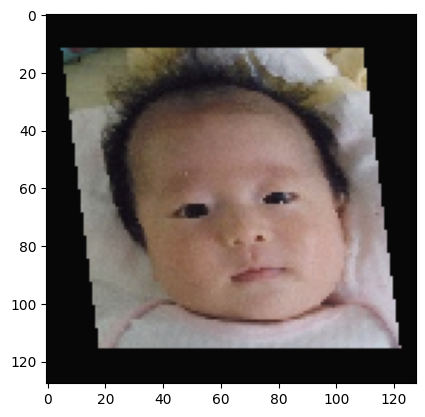

In [ ]:
print(f"Max: {torch.max(image)} Min: {torch.min(image)}")
plt.imshow(image.numpy().transpose((1, 2, 0)))

In [ ]:
def show_output(model, train_dataset):
    image = train_dataset[0][0].to(device).unsqueeze(0)
    output = model(image)
    print(f"Max: {torch.max(output)} Min: {torch.min(output)}")
    plt.imshow(output.cpu().squeeze().detach().numpy().transpose((1, 2, 0)))

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = (3,3), stride = 2, padding = 1), #64x64x32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size = (3,3), stride = 2, padding = 1), #32x32x64
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size = (3,3), stride = 2,  padding = 1), #16x16x128
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size = (3,3), stride = 2,  padding = 1), #8x8x256
            nn.BatchNorm2d(256),
            # nn.Flatten(),
            # nn.Linear(1024, 256),
            # nn.ReLU()
        )
        self.decoder = nn.Sequential(
            # nn.Linear(256, 1024),
            # nn.Unflatten(1, (64, 4, 4)),
            nn.ConvTranspose2d(256, 256, kernel_size = (2,2), stride = 2, padding = 0), #8x8x256
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size = (2,2), stride = 2, padding = 0), #16x16x128
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, kernel_size = (2,2), stride = 2, padding = 0),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, kernel_size = (2,2), stride = 2, padding = 0),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            # nn.ConvTranspose2d(32, 16, kernel_size = (2,2), stride = 2, padding = 0),
            # nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size = (1,1), stride = 1, padding = 0),
            nn.BatchNorm2d(3),
            # nn.Tanh(),
            nn.Sigmoid()
        )

    def forward(self, images):
        x = self.encoder(images)
        x = self.decoder(x)
        return x

    def encode(self, images):
        return self.encoder(images)

    def decode(self, images):
        return self.decoder(images)

In [ ]:
model = AutoEncoder()
model = model.to(device)

model.eval()
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
              ReLU-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
              ReLU-4           [-1, 64, 32, 32]               0
       BatchNorm2d-5           [-1, 64, 32, 32]             128
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8            [-1, 256, 8, 8]         295,168
       BatchNorm2d-9            [-1, 256, 8, 8]             512
  ConvTranspose2d-10          [-1, 256, 16, 16]         262,400
             ReLU-11          [-1, 256, 16, 16]               0
  ConvTranspose2d-12          [-1, 128, 32, 32]         131,200
             ReLU-13          [-1, 128, 32, 32]               0
      BatchNorm2d-14          [-1, 128,

In [ ]:
model = AutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay = 1e-5)
my_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size = 10,
                                                gamma = 0.1)

Epoch 1 | Loss: 0.012786651030182838 | Learning rate: [0.001]
Max: 0.9825940728187561 Min: 0.050701603293418884
Epoch 2 | Loss: 0.009105158969759941 | Learning rate: [0.001]
Epoch 3 | Loss: 0.006661996245384216 | Learning rate: [0.001]
Epoch 4 | Loss: 0.0036268786061555147 | Learning rate: [0.001]
Epoch 5 | Loss: 0.00361992372199893 | Learning rate: [0.001]
Epoch 6 | Loss: 0.0019059283658862114 | Learning rate: [0.001]
Epoch 7 | Loss: 0.0016302511794492602 | Learning rate: [0.001]
Epoch 8 | Loss: 0.00273063313215971 | Learning rate: [0.001]
Epoch 9 | Loss: 0.0013594204792752862 | Learning rate: [0.001]
Epoch 10 | Loss: 0.0015530295204371214 | Learning rate: [0.0001]
Epoch 11 | Loss: 0.0011689524399116635 | Learning rate: [0.0001]
Max: 0.9950132966041565 Min: 0.004561061970889568
Epoch 12 | Loss: 0.0014404815156012774 | Learning rate: [0.0001]
Epoch 13 | Loss: 0.0012156963348388672 | Learning rate: [0.0001]
Epoch 14 | Loss: 0.001360887661576271 | Learning rate: [0.0001]
Epoch 15 | Loss:

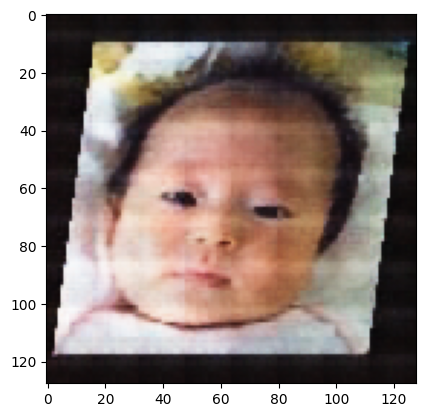

In [ ]:
epochs = 50
for epoch in range(epochs):
    model.train()
    for images, _ in train_dataloader:

        images = images.to(device)
        outputs = model(images)

        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    my_lr_scheduler.step()
    print(f"Epoch {epoch+1} | Loss: {loss.item()} | Learning rate: {my_lr_scheduler.get_last_lr()}")

    if (epoch)%10==0:
        show_output(model, train_dataset)


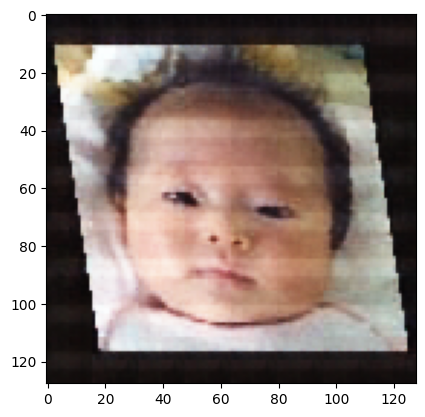

In [ ]:
    # image = train_dataset[0][0].to(device).unsqueeze(0)
    output = model(image)

    output = output.cpu().squeeze().detach().numpy().transpose((1, 2, 0))
    # mean = np.array([0.485 , 0.546, 0.406])
    # std = np.array([0.229 , 0.224 , 0.225])
    # output = std * output + mean
    # output = np.clip(output, 0, 1)


    plt.imshow(output)

In [ ]:
# torch.save(model, "autoencoder-mufac.pth")

## Apply SMOTE

In [ ]:
autoencoder = torch.load("/content/drive/MyDrive/AI/MachineUnlearn/autoencoder-mufac.pth", map_location = device)

In [ ]:
def generate_SMOTE(encoder, dataset):

    encoder.eval()
    encoder = encoder.to(device)

    features = []

    for image, label in dataset:
        feature = encoder(image.to(device).unsqueeze(0)).squeeze().detach()
        features.append((feature, label))

    X = []
    y = []

    for feature, label in features:
        X.append(nn.Flatten(0)(feature).detach().cpu().numpy())
        y.append(label)

    sm = SMOTE(random_state=42)
    X_smote, y_smote = sm.fit_resample(X[::5], y[::5])

    return X_smote, y_smote

In [ ]:
def decodeFeatures(features, decoder):
    generated_images = []

    for feature in features:
        feature = torch.Tensor(feature)
        feature = nn.Unflatten(0, (256, 8, 8))(feature).unsqueeze(0).to(device)
        generated_image = decoder(feature).squeeze().detach()
        generated_images.append(generated_image)

    return generated_images

In [ ]:
class SMOTEDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [ ]:
def finetune(model, dataloader):
    epochs = 5
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001)
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=0, last_epoch=-1, verbose=False)

    for epoch in range(epochs):
        model.train()
        running_loss = 0

        for batch_idx, (x, y) in enumerate(dataloader):
            y = y.cuda()

            # Classification Loss
            outputs = model(x.cuda())
            classification_loss = criterion(outputs, y)

            optimizer.zero_grad()
            classification_loss.backward()
            optimizer.step()
            # scheduler.step()

            running_loss += classification_loss.item() * x.size(0)
            print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(dataloader)}] - Batch Loss: {classification_loss.item():.4f}")

        average_epoch_loss = running_loss / (len(dataloader) * x.size(0))
        print(f"Epoch [{epoch+1}/{epochs}] - Total Loss: {running_loss:.4f}")

        train_acc = calculate_accuracy(model, dataloader)
        val_acc = calculate_accuracy(model, test_dataloader)

        # print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.2f}, Val Acc: {val_acc:.2f}")

    return model

In [ ]:
X_smote, y_smote = generate_SMOTE(autoencoder.encoder, train_dataset)
generated_images = decodeFeatures(X_smote, autoencoder.decode)

In [ ]:
smoteDataset = SMOTEDataset(generated_images, y_smote)
smoteLoader = DataLoader(smoteDataset, batch_size=64, shuffle=True)

In [ ]:
model = copy.deepcopy(pretrain_model)
finetune(model, smoteLoader)

Epoch [1/5], Batch [1/53] - Batch Loss: 0.9299
Epoch [1/5], Batch [2/53] - Batch Loss: 1.1009
Epoch [1/5], Batch [3/53] - Batch Loss: 1.1686
Epoch [1/5], Batch [4/53] - Batch Loss: 1.7152
Epoch [1/5], Batch [5/53] - Batch Loss: 1.4433
Epoch [1/5], Batch [6/53] - Batch Loss: 1.1622
Epoch [1/5], Batch [7/53] - Batch Loss: 1.2650
Epoch [1/5], Batch [8/53] - Batch Loss: 1.2176
Epoch [1/5], Batch [9/53] - Batch Loss: 1.4722
Epoch [1/5], Batch [10/53] - Batch Loss: 1.4221
Epoch [1/5], Batch [11/53] - Batch Loss: 0.9097
Epoch [1/5], Batch [12/53] - Batch Loss: 1.5801
Epoch [1/5], Batch [13/53] - Batch Loss: 1.0002
Epoch [1/5], Batch [14/53] - Batch Loss: 0.9442
Epoch [1/5], Batch [15/53] - Batch Loss: 0.8978
Epoch [1/5], Batch [16/53] - Batch Loss: 1.4258
Epoch [1/5], Batch [17/53] - Batch Loss: 0.9853
Epoch [1/5], Batch [18/53] - Batch Loss: 0.7169
Epoch [1/5], Batch [19/53] - Batch Loss: 0.9176
Epoch [1/5], Batch [20/53] - Batch Loss: 1.0325
Epoch [1/5], Batch [21/53] - Batch Loss: 1.0661
E

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
cal_acc(model, "SMOTE")
cal_mia(model, forget_dataloader_test)

Accuracy of SMOTE Model on Retain Set 82.5020537495599
Accuracy of SMOTE Model on Forget Set 80.45212765957447
Accuracy of SMOTE Model on Test Set 58.244680851063826
MIA Scores: 0.7918882978723404


0.7918882978723404

In [ ]:
X_new = X_smote[(train_dataset.__len__()//5)+1::]
y_new = y_smote[(train_dataset.__len__()//5)+1::]

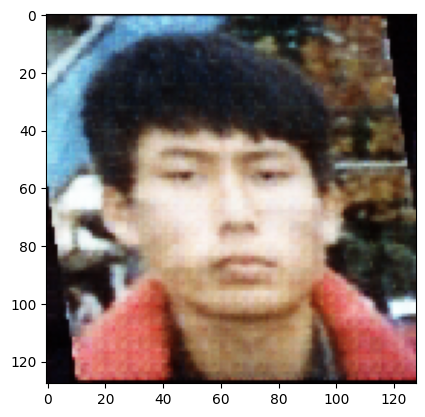

In [ ]:
image = generated_images[102]
image = image.cpu().numpy()
image = np.transpose(image, (1, 2, 0))

plt.imshow(image)

## SMOTE Features

In [ ]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [ ]:
model = copy.deepcopy(pretrain_model)
model.fc = Identity()

In [ ]:
def generate_SMOTE(encoder, dataset):

    encoder.eval()
    features = []

    for image, label in dataset:
        feature = encoder(image.to(device).unsqueeze(0)).squeeze().detach()
        features.append((feature, label))

    X = []
    y = []

    for feature, label in features:
        X.append(feature.cpu().numpy())
        y.append(label)

    sm = SMOTE(random_state=42)
    X_smote, y_smote = sm.fit_resample(X, y)

    return X_smote, y_smote

In [ ]:
X_smote, y_smote = generate_SMOTE(model, retain_dataset_test)

In [ ]:
X_new = X_smote[retain_dataset_test.__len__()::]
y_new = y_smote[retain_dataset_test.__len__()::]

In [ ]:
X_new = torch.Tensor(X_new).to(device)
y_new = torch.Tensor(y_new)

In [ ]:
pretrain_model.fc(X_new[1])

tensor([ 1.3020,  6.1935,  2.6795, -1.2737, -1.9011, -2.8444, -7.2511, -4.8940],
       device='cuda:0', grad_fn=<ViewBackward0>)

In [ ]:
y_new[1]

tensor(1.)